# Homework #8

## Problem 1

![two bodies: sliding block and compound pendulum](../images/spring_compound-2_bodies.svg)

For the system shown above, block one slides along the x-axis and is attached via a pin to a link, body 2. The system has the following characteristics, 

- $m^1 = 0.1~kg$
- $k = 40~N/m$
- $F_{spring} = -k(R_x^1-0.2)$
- $l^2 = 1~m$
- $m^2 = 1~kg$



Use the __embedding technique__ to solve for the dynamic response for the system. Separate the generalized coordinates are separated into _dependent_ and _independent_ coordinates as such 

$\mathbf{q} = [\mathbf{q}_d,~\mathbf{q}_i]$.

- $\mathbf{q}_d = [R_y^1,~\theta^1,~R_x^2,~R_y^2]$
- $\mathbf{q}_i = [R_x^1,~\theta^2]$

This distinction creates two second order differential equations, where $n=3\times(\#~bodies)$ and $n_c=number~of~constraints$. The equations of motion are as such

$\mathbf{B^TMB +B^TM\gamma-B^TQ_e = 0}$

where, 
- $\mathbf{B}=\left[\begin{array}{c}-\mathbf{C_{q_d}^{-1}C_{q_i}} \\\bar{I}\end{array}\right]$
- $\gamma = \left[\begin{array}{c}
~\mathbf{-C_{q_d}^{-1}[(C_q\dot{q})_q\dot{q}+2C_{qt}\dot{q}+C_{tt}}] \\
\mathbf{0}\end{array}\right] = \left[\begin{array}{c}
~\mathbf{C_{q_d}^{-1}[Q_d]} \\
\mathbf{0}\end{array}\right]$
- $\mathbf{C_{q_d}}~and~\mathbf{C_{q_i}}$ are the Jacobian of constraints for _dependent_ and _independent_ coordinates, respectively

You will define the following functions:
- `C_sys` the 4 constraint equations for the system
- `Cq_sys` the Jacobian of the system `d C_sys/dq`
- `Bi_link` the array $\mathbf{B}$ that transforms $\delta \mathbf{q_i}$ to $\delta \mathbf{q}$
- `eom_sys` the final equation of motion using the embedding technique

### Define $\mathbf{A}$ and $\mathbf{A}_\theta$

Here, you create two functions to rotate from the body coordinate system at angle $\theta$ to the global coordinate system. The derivate, $\mathbf{A}_\theta$ will be used in the Jacobian and equations of motion. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy

In [2]:
def rotA(theta):
    '''This function returns a 2x2 rotation matrix to convert the 
    rotated coordinate to the global coordinate system
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    A : 2x2 array to rotate a coordinate system at angle theta to global x-y
    '''
    A=np.zeros((2,2))
    A=np.array([[np.cos(theta), -np.sin(theta)],
               [np.sin(theta), np.cos(theta)]])
    
    return A

In [3]:
def A_theta(theta):
    '''This function returns a 2x2 rotation matrix derivative 
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    dAda : 2x2 array derivative of `rotA`
    '''
    dAda=np.array([[-np.sin(theta), -np.cos(theta)],
                   [np.cos(theta), -np.sin(theta)]])
    return dAda

Define Jacobian of pin constraint as `Cq_pin`.

In [4]:
def Cq_pin(qi, qj, ui, uj):
    '''Jacobian of a pinned constraint for planar motion

    Parameters
    ----------
    qi : generalized coordinates of the first body, i [Rxi, Ryi, thetai]
    qj : generalized coordinates of the 2nd body, i [Rxj, Ryj, thetaj]
    ui : position of the pin the body-i coordinate system
    uj : position of the pin the body-j coordinate system
        
    Returns
    -------
    Cq_pin : 2 rows x 6 columns Jacobian of pin constraint Cpin
    '''
    
    Cq_1=np.block([np.eye(2), A_theta(qi[2])@ui[:,np.newaxis] ])
    Cq_2=np.block([-np.eye(2), -A_theta(qj[2])@uj[:,np.newaxis] ])
    Cq_pin=np.block([Cq_1, Cq_2])
    return Cq_pin

In [5]:
m1 = 0.1
k = 40
l2 = 1
m2 = 1

In [6]:
def C_sys(q,t):
    C= np.zeros(4)
    C[0] = q[0]- q[3] +l2/2*np.cos(q[5])
    C[1] = q[1] - q[4] + l2/2*np.sin(q[5])
    C[2] = q[1]
    C[3] = q[2]

    return C

In [7]:
def Cq_sys(q,t):
    Cq = np.zeros([4,6])
    
    Cq[0:2,0:2] = np.eye(2)
    Cq[2:4,1:3] = np.eye(2)
    Cq[0:2,3:5] = -np.eye(2)
    Cq[0,-1] = -l2/2*np.sin(q[5])
    Cq[1,-1] = l2/2*np.cos(q[5])

    return Cq

In [8]:
def Bi_link(Cq_sys):
    Cqd = Cq_sys[:,5]
    Cqi = Cq_sys[:,-1]
    B = np.zeros([6,2])
    B[:4,:] = np.linalg.solve(Cqd,Cqi)
    
    return B, Cqd,Cqi

In [9]:
def eom_sys(q,dq,Q_e,t):
    C = C_sys(q,t)
    Cq = Cq_sys(q,t)
    B,Cqd,Cqi = Bi_link(Cq)

    Qd = np.zeros(4)
    Qd[0]= l2/2*dq[5]**2*np.cos(q[5])
    Qd[1]= l2/2*dq[5]**2*np.sin(q[5])

    gamma = np.array([np.linalg.inv(Cqd)@Qd,0])
    M = np.array([[m1,0],[0,m2]])
    eom = B.T@M@B - B.T@M@gamma - B.T@Q_e 
    return eom

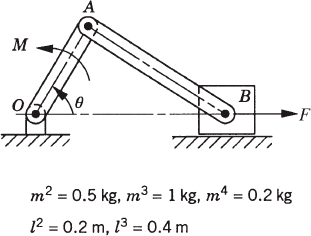

## Problem 2

Create the system of equations using the __augmented technique__. Solve these equations numerically using `solve_ivp` and plot the position and orientation of the links for one revolution of the crankshaft. Assume that $M^2$ = 10N-m, $F^4$ = 15N, $\theta^2$ = 45 $^o$, and $\dot{\theta}^2$=150 rad/s.

The __augmented technique__ is a generalized method to solve for the dynamic response in a system of moving parts. The system of _differential algebraic equations_ (DAE) are solve for all generalized coordinates and constraint forces in a system of equations, 

$\left[\begin{array}{}
~\mathbf{M} & \mathbf{C_q}^T \\
\mathbf{C_q} & \mathbf{0} \end{array}\right]
\left[\begin{array}{}
~\mathbf{\ddot{q}} \\
\mathbf{\lambda}\end{array}\right] =
\left[\begin{array}{}
~\mathbf{Q_e}  \\
\mathbf{Q_d}\end{array}\right]$


- Plot the angles of the two connecting links and the position of the sliding block at point B. 
- Plot the reaction forces at O, A, and B. 

In [10]:
from scipy.integrate import solve_ivp

In [11]:
def Qd_slidercrank(q, dq, t):
    '''return slidercrank Qd = Cq@ddq

    Parameters
    ----------
    q : numpy array for 9 generalized coordinates for bodies 1-3 in the slider crank
        q = [q1, q2, q3]
    t : current time
    Returns
    -------
    Qd : 1D array with length 9     
    '''
    l1, l2 = 0.2,0.4
    q1 = q[0:3]
    q2 = q[3:6]
    q3 = q[6:9]
    dq1 = dq[0:3]
    dq2 = dq[3:6]
    dq3 = dq[6:9]
    
    Qd=np.zeros(8)
    Qd[0:2] = dq1[2]**2*rotA(q1[2])@np.array([-l1/2, 0])
    Qd[2:4] = dq1[2]**2*rotA(q1[2])@np.array([l1/2, 0]) -\
              dq2[2]**2*rotA(q2[2])@np.array([-l2/2, 0])
    Qd[4:6] = dq2[2]**2*rotA(q2[2])@np.array([l2/2, 0])
    Qd[6:8] = 0
    return Qd

In [12]:
def Cq_slidercrank(q,t):
    '''return Jacobian of C_slidercrank(q,t) = dC/dq_i
       |dC1/dR1x dC1/dR1y ... dC9/da3 |
       |dC2/dR1x dC2/dR1y ... dC9/da3 |
       |... ..     .           ...    |
       |            .                 |
       |             .                |
       |dC9/dR1x ...         dC9/da3  |
    Parameters
    ----------
    q : numpy array for 9 generalized coordinates for bodies 1-3 in the slider crank
        q = [q1, q2, q3]
    t : current time
    Returns
    -------
    Cq : 9 rows x 9 columns Jacobian of constraints `C_slidercrank`   
    '''
    l1, l2 = 0.2,0.4
    q1 = q[0:3]
    q2 = q[3:6]
    q3 = q[6:9]
    
    Cq=np.zeros((8,9))
    Cq[0:2, 0:3] = Cq_pin(q1, np.array([0, 0, 0]),np.array([-l1/2, 0]),np.array([0, 0]))[0:2, 0:3]
    Cq[2:4, 0:6] = Cq_pin(q1, q2, np.array([l1/2, 0]), np.array([-l2/2, 0]))
    Cq[4:6, 3:10] = Cq_pin(q2, q3, np.array([l2/2, 0]), np.array([0, 0]))
    Cq[6:8, 7:10] = np.eye(2)
    return Cq

In [20]:
m1 = 0.5
m2= 1
m3=0.2
torque = 10
F4 = 15
g= 9.81
theta2 = np.deg2rad(45)
theta_dot2 = 150
l1=0.2
l2=0.4
def eom_slider(t,y):
    q = y[0:9]
    dq = y[9:]
    Cq = Cq_slidercrank(q,t)
    Qd = Qd_slidercrank(q, dq,t)
    Qe = np.array([0,
                   -m1*g,
                   torque,
                   0,
                   -m2*g,
                   0,
                   F4,
                   -m3*g,
                   0])
    
    M = np.diag([m1,m1,m1*l1**2/l2,
                 m2,m2,m2*l2**2/l2,
                 m3,m3,m3])
    Aug = np.block([[M, Cq.T],
                     [Cq, np.zeros([8,8])]])
    rhs = np.hstack([Qe,Qd])

    ddq_lambda = np.linalg.solve(Aug,rhs)
    dy = np.zeros(18)
    dy[0:9] = dq
    dy[9:] = ddq_lambda[0:9]
    forces = ddq_lambda[9:]
    return dy,forces

In [41]:
y = np.ones(18)
y[5] = theta2
solution = solve_ivp(lambda t,y: eom_slider(0,y)[0],[0,2],y,t_eval=np.linspace(0,2))


Text(0, 0.5, 'Angle (rad)')

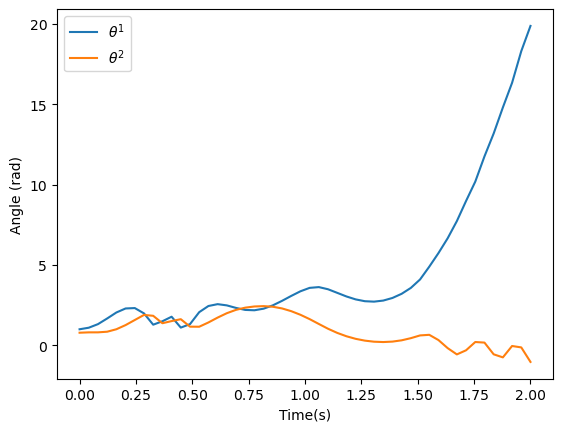

In [44]:
plt.plot(solution.t,solution.y[2],label=r'$\theta^1$')
plt.plot(solution.t,solution.y[5],label=r'$\theta^2$')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Angle (rad)')

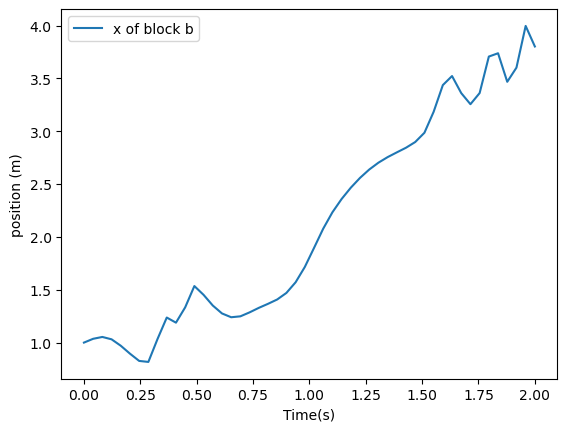

In [87]:
plt.plot(solution.t,solution.y[6],label='x of block b')
plt.xlabel('Time(s)')
plt.ylabel('position (m)')
plt.legend()